# Milestone 2 - Home Values
Version: Jun-2019

## Author - Lukas Fiorio

# Abstract

## Problem

Problem Statement: We need to understand the value of a home's features and attributes on its overall value

We first visually examine the relationship between a home's sale price and its features to build this understanding.  Next, we apply statistical analysis and hypothesis testing to identify likely distributions and confidence intervals for our features. 

In a later module, we will build a predictive model based on these relationships.

## Conclusion

Many features should have predictive power in determining a home's sale price.

Analysis by Census Tract shows strong association with price (as well as several other measures, such as square footage, price per square foot, lot space, and waterfront status).

By examining data transformations, we were able to find likely distributions for many of our features. Price appeared to mostly closely follow a box-cox distribution (although log distribution was also a good approximation).

Through statistical analysis of categorical features, we were able to find statistically significant differences in sale price among pairwise comparisons of the following:

- \# of bedrooms
- view quality
- building condition
- building grade
- renovation status
- \# of floors
- waterfront status

\# of bedrooms was a very strong predictor up until 5+.  View quality made only slight (or no) difference until top-tier (4) was hit.  Condition made only slight (or no) difference unless bottom tiers (2) were hit.  Building grade appears to have increasing affect as grade increased (ex: 11 to 12 more important than 5 to 6).  Renovation & waterfront status each had clear, strong affects.  # of floors had only slight effect, other than 2.5 floor buildings, which were much higher priced.

# Analysis

### Note: several packages must be downloaded if not already in environment

`activate uwdatasci400`<br>
`conda install -c scitools cartopy` <br>
`conda install pyproj` <br>
`conda install geopandas` <br>
`conda install descartes` <br>

`pip install geoplot` <br>

- `shapely` should also get installed as dependency

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as ss
import statsmodels.api as sm

from scipy.stats import mstats
from IPython.display import display

from pyproj import CRS
import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes

import geoplot

In [2]:
# set package options
pd.set_option('display.max_columns', None) # show all columns
# pd.set_option('display.max_rows', None) # show all rows 
# plt.rc('figure', max_open_warning = 0) # set warning option for # of open plots
plt.rc('patch', force_edgecolor = True) # set bar borders in bar plots

In [3]:
# Locate & load dataset
file = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/kc_house_data.csv"
kc_homes = pd.read_csv(file) # read file into df

### Explore the dataset

| Field | Description | Units |
| :- | :- | :- |
| id | unique identifier for each property | |
| date | date sold | day |
| price | sale price | $ |
| bedrooms | number of bedrooms | # count |
| bathrooms | number of bathrooms | # count |
| sqft_living | size of living area | # square feet |
| sqft_lot | size of lot | # square feet |
| floors | number of floors | # count |
| waterfront | indicates whether property overlooks a waterfront | 0, 1 |
| view | quality of the property's view | index: 0 to 4 (poor to excellent) |
| condition | condition of the house | index: 1 to 5 (poor to excellent) |
| grade | construction quality, based on quality of materials/workmanship | index: 1 to 13 (poor to excellent) |
| sqft_above | size of living area - above ground | # square feet |
| sqft_basement | size of living area - below ground | # square feet |
| yr_built | year built | year |
| yr_renovated | year renovated | year (0 if never renovated) |
| zipcode | 5 digit zip code | |
| lat | latitude coordinates | |
| long | longitude coordinates | |
| sqft_living15 | nearest 15 properties: average size of living area | # square feet |
| sqft_lot15 | nearest 15 properties: average size of lot (square feet) | # square feet |

sources: 
- [King County Residential Glossary](https://blue.kingcounty.com/assessor/erealproperty/ResidentialGlossary.aspx)
- [GeoDa Data and Lab: King County House Sales](https://geodacenter.github.io/data-and-lab//KingCounty-HouseSales2015/)

In [4]:
kc_homes.head() # preview data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


#### note: no nulls, all numeric (except `date`)

In [5]:
kc_homes.info() # data structure

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

#### Interesting notes:

- max(bedrooms) = 33.  Likely a data issue or outlier that needs to be treated.
- min(bathrooms) = 0.  Likely a data issue or outlier that needs to be treated.

In [6]:
kc_homes.describe().apply(lambda s: s.apply(lambda x: format(x, 'g'))) # describe df (rounded)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613
mean,4.5803e+09,540088,3.37084,2.11476,2079.9,15107,1.49431,0.00754176,0.234303,3.40943,7.65687,1788.39,291.509,1971.01,84.4023,98077.9,47.5601,-122.214,1986.55,12768.5
std,2.87657e+09,367127,0.930062,0.770163,918.441,41420.5,0.539989,0.0865172,0.766318,0.650743,1.17546,828.091,442.575,29.3734,401.679,53.505,0.138564,0.140828,685.391,27304.2
min,1.0001e+06,75000,0,0,290,520,1,0,0,1,1,290,0,1900,0,98001,47.1559,-122.519,399,651
25%,2.12305e+09,321950,3,1.75,1427,5040,1,0,0,3,7,1190,0,1951,0,98033,47.471,-122.328,1490,5100
50%,3.90493e+09,450000,3,2.25,1910,7618,1.5,0,0,3,7,1560,0,1975,0,98065,47.5718,-122.23,1840,7620
75%,7.3089e+09,645000,4,2.5,2550,10688,2,0,0,4,8,2210,560,1997,0,98118,47.678,-122.125,2360,10083
max,9.9e+09,7.7e+06,33,8,13540,1.65136e+06,3.5,1,4,5,13,9410,4820,2015,2015,98199,47.7776,-121.315,6210,871200


### Data clean up

- investigate a few suspicious records

#### in particular 0 bathrooms, look suspicious

- 0 bed, 0 bath = 7 records
- 1 bed, 0 bath = 3 records

In [7]:
# count of properties by # of bathrooms/bedrooms
pd.crosstab(kc_homes['bedrooms'], kc_homes['bathrooms'])

bathrooms,0.00,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.50,7.75,8.00
bedrooms,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,7,0,1,1,0,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,1,27,138,2,12,4,6,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,2,26,1558,3,294,304,216,118,197,20,13,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,16,1780,4,829,1870,1048,1082,2357,275,197,184,143,17,11,6,5,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,2,325,0,254,719,525,709,2502,639,326,254,395,78,58,38,32,7,7,5,5,1,0,0,0,0,0,0,0
5,0,0,0,43,0,48,134,110,116,287,214,163,129,169,44,48,25,35,11,7,4,4,2,4,2,1,1,0,0,0
6,0,0,0,6,0,6,16,24,15,29,31,45,12,17,13,11,8,23,3,6,3,0,0,1,0,1,0,0,1,1
7,0,0,0,1,0,2,0,0,3,2,3,3,1,5,2,5,2,3,2,0,0,1,1,0,0,0,1,0,0,1
8,0,0,0,0,0,0,0,0,0,1,3,2,1,1,1,2,0,0,0,1,0,0,0,1,0,0,0,0,0,0


#### 0 bed, 0 bath has 2000+ sqft on average... seems off.  1 bed, 0 bath is maybe OK.

- based on this, we'll drop records with 0 bed, 0 bath. most likely erroneous

In [8]:
# mean sqft by bathroom, bedroom sqft
pd.crosstab(kc_homes['bedrooms'], kc_homes['bathrooms'], values = kc_homes['sqft_living'], aggfunc = 'mean')

bathrooms,0.00,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.50,7.75,8.00
bedrooms,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2058.285714,NaN,384.000000,390.000000,NaN,1430.000000,NaN,NaN,NaN,1863.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,653.333333,880.0,686.296296,823.550725,1455.0,1111.500000,1055.000000,1565.000000,1840.000000,1900.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,880.0,907.769231,1038.086008,1110.0,1275.238095,1556.223684,1456.490741,1575.262712,1744.497462,1895.350000,1950.769231,2212.500000,2560.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,1165.000000,1253.724157,1872.5,1524.612786,1707.221390,1723.029580,1917.627542,2138.172677,2398.141818,2426.903553,2442.456522,2653.258741,3336.470588,3374.545455,4076.666667,4276.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,2300.0,1700.000000,1528.338462,NaN,1824.933071,2010.549374,1967.933333,2341.781382,2601.766587,2727.762128,2817.849693,3561.059055,3571.253165,3797.435897,4173.586207,4593.868421,4461.718750,4532.142857,5183.571429,5332.000000,6430.0,7220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,1810.697674,NaN,2063.333333,2185.238806,2223.545455,2673.362069,2775.724739,2829.261682,2946.576687,3678.759690,3660.112426,3987.500000,4196.375000,4514.800000,4703.342857,5649.545455,5372.000000,5335.000000,6570.0,8465.0,6732.5,8345.0,7270.0,9640.0,NaN,NaN,NaN
6,NaN,NaN,NaN,1626.666667,NaN,2006.666667,2346.875000,2353.333333,3093.066667,3011.241379,3221.290323,2836.977778,3673.333333,3549.588235,3586.153846,3765.454545,5487.500000,3900.086957,5596.666667,4200.000000,4206.666667,NaN,NaN,7390.0,NaN,6260.0,NaN,NaN,9890.0,12050.0
7,NaN,NaN,NaN,2350.000000,NaN,2665.000000,NaN,NaN,3016.666667,2260.000000,2943.333333,3696.666667,4340.000000,3540.000000,3705.000000,3078.000000,4170.000000,4880.000000,5340.000000,NaN,NaN,6630.0,3700.0,NaN,NaN,NaN,7480.0,NaN,NaN,13540.0
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2280.000000,3120.000000,3345.000000,4300.000000,4440.000000,3460.000000,5865.000000,NaN,NaN,NaN,2800.000000,NaN,NaN,NaN,4340.0,NaN,NaN,NaN,NaN,NaN,NaN


#### Look into the 33 bedrooms property

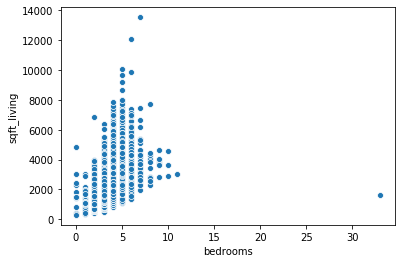

In [9]:
# plotting against square feet; clearly an outlier. maybe a data input typo?
sns.scatterplot('bedrooms', 'sqft_living', data = kc_homes);

#### Evaluate means by category just to see if it's a giant mansin

- it's not. in fact it appears to just be a 3 bedroom house that was fat-fingered. we'll make that update as well.

In [10]:
# seems very likely that '33' should be '3'
display(kc_homes.groupby('bedrooms').mean()) # take df.mean by # of bedrooms

,id,price,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
bedrooms,,,,,,,,,,,,,,,,,,,
0,4.632838e+09,4.095038e+05,0.826923,1707.846154,24141.307692,1.961538,0.000000,0.307692,2.846154,6.692308,1707.846154,0.000000,1983.846154,0.000000,98066.692308,47.511415,-122.150231,2036.923077,26097.076923
1,4.143251e+09,3.176429e+05,1.066583,884.613065,16285.673367,1.150754,0.025126,0.246231,3.266332,6.100503,823.859296,60.753769,1942.663317,169.638191,98103.417085,47.567169,-122.256854,1449.567839,14240.221106
2,4.636499e+09,4.013727e+05,1.401721,1239.752899,12096.726087,1.306703,0.011232,0.178623,3.377899,6.871739,1107.240942,132.511957,1955.413043,81.382609,98105.953623,47.588601,-122.278570,1503.785507,9693.109058
3,4.535884e+09,4.662321e+05,1.968394,1805.837235,14414.790208,1.449410,0.006515,0.187805,3.415513,7.472516,1584.442284,221.394951,1971.812602,76.001425,98076.478217,47.551478,-122.213344,1835.443506,12809.343648
4,4.658470e+09,6.354195e+05,2.436428,2554.649666,16720.793374,1.616100,0.005812,0.268091,3.406568,8.116681,2198.300639,356.349026,1976.594740,87.112467,98069.749201,47.556118,-122.189139,2291.124818,13727.256030
5,4.517188e+09,7.865998e+05,2.778576,3047.545284,16769.022486,1.579638,0.011868,0.409744,3.449094,8.272330,2407.566521,639.978763,1974.204872,101.061836,98070.188007,47.574169,-122.201242,2442.706433,13089.471580
6,4.391720e+09,8.255206e+05,3.068015,3284.341912,18586.930147,1.606618,0.014706,0.544118,3.470588,8.080882,2494.386029,789.955882,1963.036765,168.573529,98079.463235,47.580421,-122.240728,2280.176471,14756.878676
7,4.027151e+09,9.511847e+05,3.651316,3974.210526,20840.552632,1.723684,0.000000,0.500000,3.447368,8.447368,3160.263158,813.947368,1962.842105,210.657895,98085.815789,47.609024,-122.240711,2335.263158,15811.289474
8,4.684170e+09,1.105077e+06,3.557692,3800.000000,8971.615385,1.692308,0.000000,0.230769,3.538462,8.076923,2660.769231,1139.230769,1956.307692,0.000000,98081.846154,47.630008,-122.268769,2265.384615,7355.923077


#### check for discrepancies between year built and year renovated

- no discrepancies

In [11]:
# count of properties with a renovation before originally built
kc_homes[
    (kc_homes['yr_renovated'] < kc_homes['yr_built']) &
    (kc_homes['yr_renovated'] != 0)
].shape[0] # shape[0] >> of qualified rows

0

#### verify that total square footage == basement + above ground square footage

- no discrepancies (always match)

In [12]:
kc_homes[
    (kc_homes['sqft_living'] != kc_homes['sqft_above'] + kc_homes['sqft_basement'])
].shape[0] # shape[0] >> of qualified rows

0

### look for outliers in our most susceptible feature columns

- `sqft_living`
- `sqft_lot`
- `sqft_above`
- `sqft_basement` 
- `sqft_living15`
- `sqft_lot15`

#### take an initial look at top values

In [13]:
# top 5 records based on sq ft of living space
kc_homes.nlargest(5, ['sqft_living']) 

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
12777,1225069038,20140505T000000,2280000.0,7,8.00,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800
7252,6762700020,20141013T000000,7700000.0,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
3914,9808700762,20140611T000000,7062500.0,5,4.50,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
9254,9208900037,20140919T000000,6885000.0,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730
8092,1924059029,20140617T000000,4668000.0,5,6.75,9640,13068,1.0,1,4,3,12,4820,4820,1983,2009,98040,47.5570,-122.210,3270,10454


#### visual inspection across all columns

<Figure size 432x288 with 0 Axes>

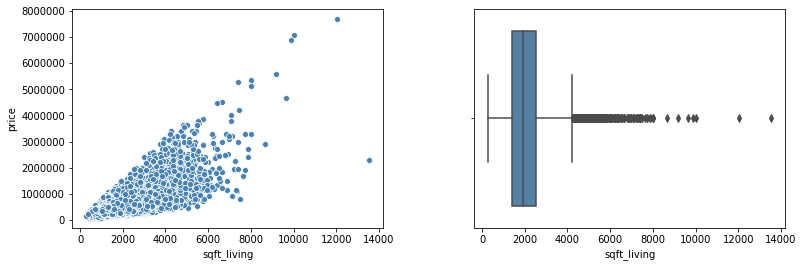

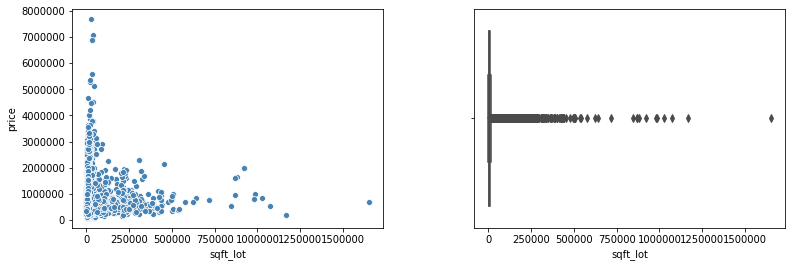

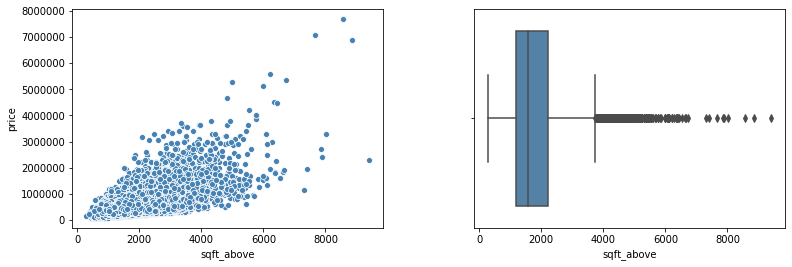

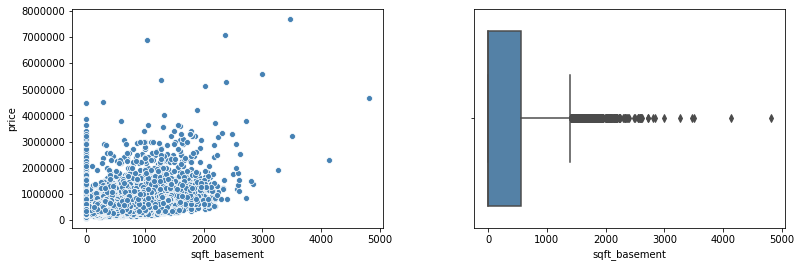

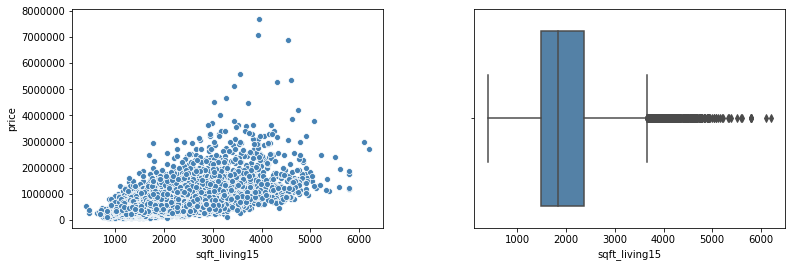

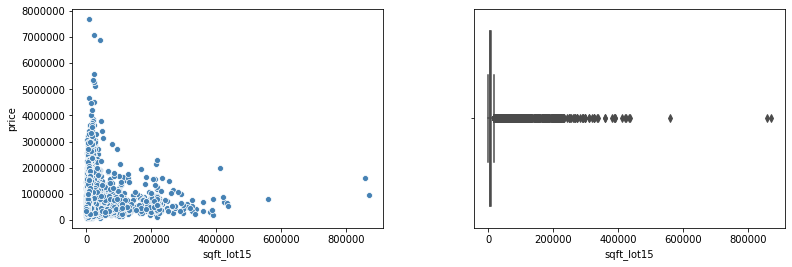

In [14]:
# declare columns to loop through
outlier_cols = [
    'sqft_living', 'sqft_lot',
    'sqft_above', 'sqft_basement', 
    'sqft_living15', 'sqft_lot15'
    ]

for i, col in enumerate(kc_homes[outlier_cols].columns):    
    plt.figure(i)
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(12, 5)
    fig.tight_layout(pad=6.0)
    g1 = sns.scatterplot(x = col, y = 'price', data = kc_homes, color='steelblue', ax=ax[0]);
    g2 = sns.boxplot(x = col, data = kc_homes, color='steelblue', ax=ax[1]);

#### based on above plots, let's winsorize each of these columns by capping at the 99th percentile

- `price` itself may also have outliers, but we will leave as is for now
- noted that `sqft_living` will now no longer match `SUM(sqft_above, sqft_basement)`

In [15]:
# cap outliers at 99th percentile
for col in kc_homes[outlier_cols]:
    kc_homes[col] = mstats.winsorize(kc_homes[col], limits=[0.00, 0.01])

#### take a peak at "new" highest values

In [16]:
# top values of sqft_living now capped at ~5,000 sqft
# as noted, no longer matches sum(sqft_above, sqft_basement)
kc_homes.nlargest(5, ['sqft_living']) 

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
5,7237550310,20140512T000000,1225000.0,4,4.50,4980,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4080,101930
153,7855801670,20150401T000000,2250000.0,4,3.25,4980,19850,2.0,0,3,3,12,3540,1640,2006,0,98006,47.5620,-122.162,3160,9750
269,7960900060,20150504T000000,2900000.0,4,3.25,4980,20100,1.5,0,2,3,11,4370,300,1982,2008,98004,47.6312,-122.223,3890,20060
270,4054500390,20141007T000000,1365000.0,4,4.75,4980,57346,2.0,0,0,4,11,4370,0,1989,0,98077,47.7285,-122.042,4080,47443
419,8678500060,20140710T000000,1550000.0,5,4.25,4980,171626,2.0,0,0,3,12,4370,0,1999,0,98024,47.5954,-121.950,4080,157687


#### Make remaining data changes

- drop 0 bed, 0 bath records (7)
- replace 33 beds with 3 beds
- set the `date` column to date type

In [17]:
# drop records (properties) with no bedrooms or bathrooms
kc_homes = kc_homes.drop(
    kc_homes[
        (kc_homes['bathrooms'] == 0) & 
        (kc_homes['bedrooms'] == 0)
    ].index).reset_index(drop=True)

In [18]:
# replace 33 bedrooms outlier with assumed value (3)
kc_homes['bedrooms'] = kc_homes['bedrooms'].replace(33, 3)

In [19]:
# set the date column to date
kc_homes['date'] =  pd.to_datetime(kc_homes['date'])

### feature engineering

- `is_renovated` - {0, 1} indicates whether a property has been renovated
- `update_age` - [0, 115] years (from 2015) since built or renovated; whichever is more recent

In [20]:
kc_homes['is_renovated'] = (kc_homes['yr_renovated'] > 0).astype('int')
kc_homes['update_age'] = 2015 - kc_homes[['yr_built', 'yr_renovated']].max(axis = 1)

In [21]:
# preview data
kc_homes.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_renovated,update_age
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,0,60
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,1,24
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,0,82
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,0,50
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,0,28


### pairplot

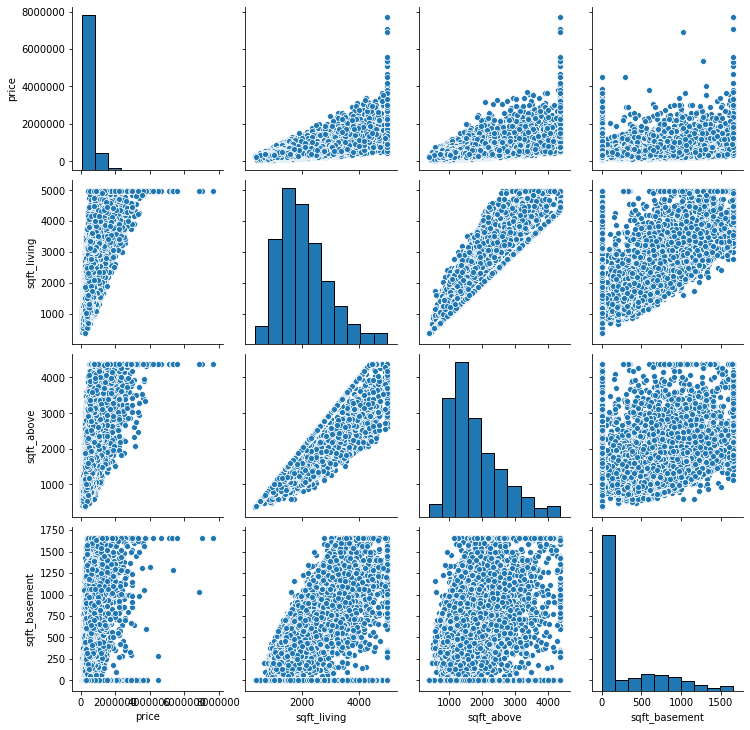

In [22]:
# examine relationship betwen price & indoor sq footage
pp_cols = [
    'price','sqft_living',
    'sqft_above', 'sqft_basement',
    ]
sns.pairplot(kc_homes[pp_cols]);

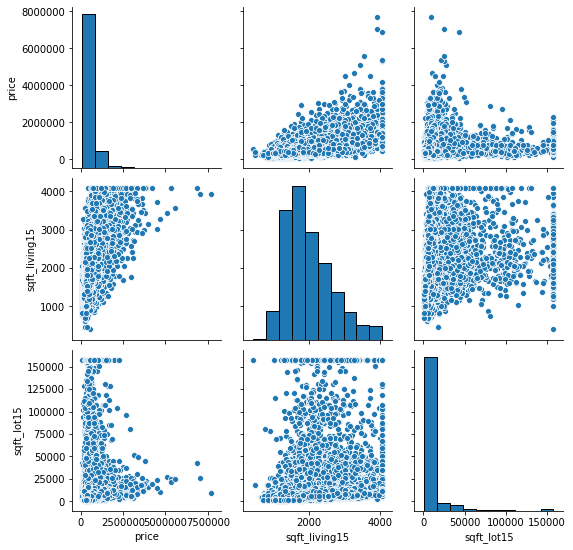

In [23]:
# examine relationship between price and neighbors' sq footage
pp_cols = [
    'price', 'sqft_living15', 'sqft_lot15'
    ]

# pairwise plot
sns.pairplot(kc_homes[pp_cols]);

### heat map

### import shapely file

- original source: [gis-kingcounty.opendata: ACS Housing Units](https://gis-kingcounty.opendata.arcgis.com/datasets/acs-housing-units-acs-b25001-housingunits)

- download source: [github.com/lukefiorio/kc_housing_units_shp](https://github.com/lukefiorio/kc_housing_units_shp)

# Note!!  This code downloads a zip file from the github repo listed above.

- zip file contains the `.shp` file used for mapping (and is originally sourced from gis-kingcounty)
- downloads into the user's `/data` directory (assumes working directory contains a `/data` directory)
- unzips the file and then removes the original zipped file

***

In [24]:
# import packages for download, unzip, and remove zip
import requests
import zipfile
import os

In [25]:
# make API request to pull down github repo
url = 'https://github.com/lukefiorio/kc_housing_units_shp/archive/master.zip'
r = requests.get(url)

In [26]:
# set file path, name
file_name = 'data/lukefiorio_kc_housing_units_repo.zip'

# write zip file
with open(file_name, 'wb') as fd:
    for chunk in r.iter_content(chunk_size=128):
        fd.write(chunk)

In [27]:
# unzip the file
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall('data')
    
# remove the original zipped file
os.remove(file_name)

In [28]:
# read in shp file for geo-plotting
repo_dir = 'data/kc_housing_units_shp-master/acs_b25001_housingunits/'
kc_map = gpd.read_file(repo_dir + "ACS%3A_Housing_Units___acs_b25001_housingunits.shp")

FYI: original code to locally read in shp

In [29]:
# locally read in shp file for geo-plotting
# kc_map = gpd.read_file("data/acs_b25001_housingunits/ACS%3A_Housing_Units___acs_b25001_housingunits.shp")

#### inspect our map file (geo-df)

In [30]:
display(kc_map.info())
display(kc_map.head())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    398 non-null    int64   
 1   GEO_ID_TRT  398 non-null    object  
 2   TRACT_LBL   398 non-null    object  
 3   E25001001   398 non-null    int64   
 4   M25001001   398 non-null    int64   
 5   geometry    398 non-null    geometry
dtypes: geometry(1), int64(3), object(2)
memory usage: 18.8+ KB


None

,OBJECTID,GEO_ID_TRT,TRACT_LBL,E25001001,M25001001,geometry
0,1,53033000100,Tract 000100,4030,88,"POLYGON ((-122.28580 47.73368, -122.28559 47.7..."
1,2,53033000200,Tract 000200,3849,49,"POLYGON ((-122.32359 47.73405, -122.32348 47.7..."
2,3,53033000300,Tract 000300,1212,21,"POLYGON ((-122.32555 47.73407, -122.32532 47.7..."
3,4,53033000401,Tract 000401,4017,89,"POLYGON ((-122.34501 47.72633, -122.34498 47.7..."
4,5,53033000402,Tract 000402,2502,73,"POLYGON ((-122.34737 47.72322, -122.34655 47.7..."


### Set coordinate reference system & create Point objects

- epsg:4326 >> WGS84 latitude-longitude projection
- store longitude and lattitude coordinates in `Point` objects
- append geographic info to `kc_homes` df

In [31]:
# set coordinate system
crs = CRS("epsg:4326")

# convert (long, lat) coords into Point objects
points = [Point(xy) for xy in zip(kc_homes['long'], kc_homes['lat'])] 

In [32]:
# append geometry (points) to df
kc_homes = gpd.GeoDataFrame(kc_homes, crs = crs, geometry = points)

# append census tract info to df
kc_homes = gpd.sjoin(kc_homes, kc_map, how='left', op='within')

In [33]:
# set cols to avg by
geo_tract_cols = ['price', 'sqft_living', 'sqft_lot', 'waterfront']

# compute means & counts by census tract
kc_means = kc_homes.groupby(['GEO_ID_TRT'])[geo_tract_cols].mean().reset_index()
kc_counts = kc_homes.groupby(['GEO_ID_TRT'])['id'].count().reset_index().rename(columns = {'id': 'count'})

# join/append to geo_df
geo_tract_stats = kc_map.set_index('GEO_ID_TRT').join(
    kc_means.set_index('GEO_ID_TRT')).join(
    kc_counts.set_index('GEO_ID_TRT'))

#### preview dataframes

In [34]:
kc_homes.head() # preview df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_renovated,update_age,geometry,index_right,OBJECTID,GEO_ID_TRT,TRACT_LBL,E25001001,M25001001
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,0,60,POINT (-122.25700 47.51120),129.0,130.0,53033011900,Tract 011900,2686.0,83.0
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,1,24,POINT (-122.31900 47.72100),1.0,2.0,53033000200,Tract 000200,3849.0,49.0
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,0,82,POINT (-122.23300 47.73790),161.0,162.0,53033022102,Tract 022102,2488.0,62.0
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,0,50,POINT (-122.39300 47.52080),126.0,127.0,53033011600,Tract 011600,3231.0,33.0
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,0,28,POINT (-122.04500 47.61680),375.0,376.0,53033032317,Tract 032317,2200.0,49.0


In [35]:
geo_tract_stats.head() # preview geo_df

,OBJECTID,TRACT_LBL,E25001001,M25001001,geometry,price,sqft_living,sqft_lot,waterfront,count
GEO_ID_TRT,,,,,,,,,,
53033000100,1,Tract 000100,4030,88,"POLYGON ((-122.28580 47.73368, -122.28559 47.7...",525288.127273,1920.672727,8527.909091,0.054545,55.0
53033000200,2,Tract 000200,3849,49,"POLYGON ((-122.32359 47.73405, -122.32348 47.7...",397754.402174,1630.489130,7846.836957,0.000000,92.0
53033000300,3,Tract 000300,1212,21,"POLYGON ((-122.32555 47.73407, -122.32532 47.7...",373261.839286,1443.571429,5773.232143,0.000000,56.0
53033000401,4,Tract 000401,4017,89,"POLYGON ((-122.34501 47.72633, -122.34498 47.7...",433900.000000,1662.258065,6343.548387,0.000000,31.0
53033000402,5,Tract 000402,2502,73,"POLYGON ((-122.34737 47.72322, -122.34655 47.7...",431770.000000,1674.822222,6737.022222,0.000000,45.0


***

#### FYI: The original attempt at appending census tract info to df (via API calls).  Too slow!  Keeping code for posterity

define a function to convert longitude and lattitude coordinates to geo_id tract

In [36]:
# Python wrapper for the US Census Geocoder API 
# (https://geocoding.geo.census.gov/geocoder/)
# import censusgeocode as cg 

In [37]:
# # geo_id_tract = concat('53033', [tract])
# def set_geo_id(long, lat):    
#     # round the (long, lat) coords because api cannot handle if too many decimals
#     return '53033' + cg.coordinates(x = round(long, 4), y = round(lat, 4))['2010 Census Blocks'][0]['TRACT']

test on a few records to make sure it works... (it does)

In [38]:
# kc_homes_small = kc_homes[:5].copy()
# kc_homes_small['geo_id_tract'] = kc_homes_small.apply(lambda row: set_geo_id(row['long'], row['lat']), axis = 1)
# kc_homes_small.head()

run on the full df - unfortunately took forever.  Not plausible.  :(

In [39]:
# kc_homes['geo_id_tract'] = kc_homes.apply(lambda row: set_geo_id(row['long'], row['lat']), axis = 1)

***

### make the maps

### first let's look at the distribution of properties

- easy to see pockets of high density areas toward the west-ish side of King County

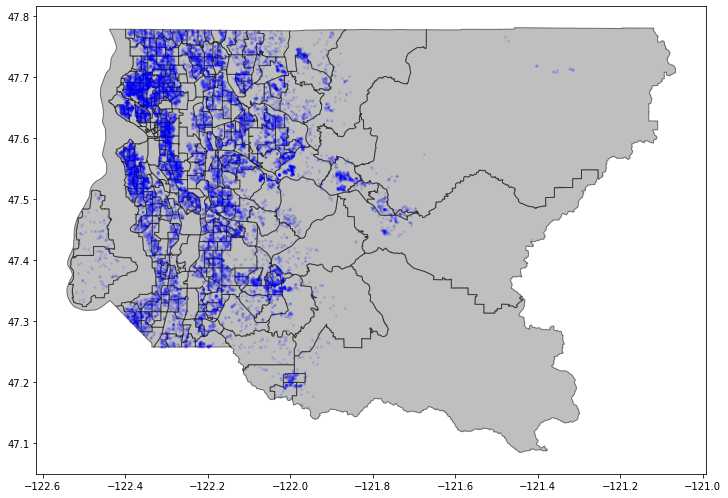

In [40]:
fig, ax = plt.subplots(figsize = (12, 12))
kc_map.plot(ax = ax, alpha = 0.5, color = 'grey')
kc_homes.plot(ax = ax, markersize = 3, color = 'blue', alpha = 0.1, marker = 'o');

#### calculate `price_per_sqft`  for fun mapping

- `property_density` would also be a cool one, but don't know how to get tract size

In [41]:
# calc price per sqft
geo_tract_stats['price_per_sqft'] = round(geo_tract_stats['price'] / geo_tract_stats['sqft_living'], 0)

#### define function for choropleth maps

In [42]:
# define function to draw choropleth maps
def plot_choropleth(geo_df, hue, metric):
    ax = geo_df.plot(
        column = hue,
        cmap = 'Blues',
        figsize = (12, 12),
        linewidth = 0.1,
        legend = True,
        legend_kwds = {'shrink': 0.5}) # shrink the legend

    ax.set_title('\nKing County Properties:\n' + metric + ', by Census Tract\n', 
                 fontsize=16);

### make choropleths!!

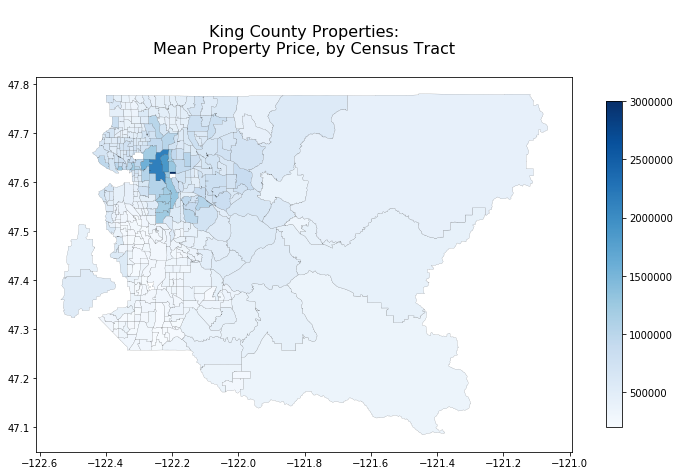

In [43]:
plot_choropleth(geo_tract_stats, 'price', 'Mean Property Price')

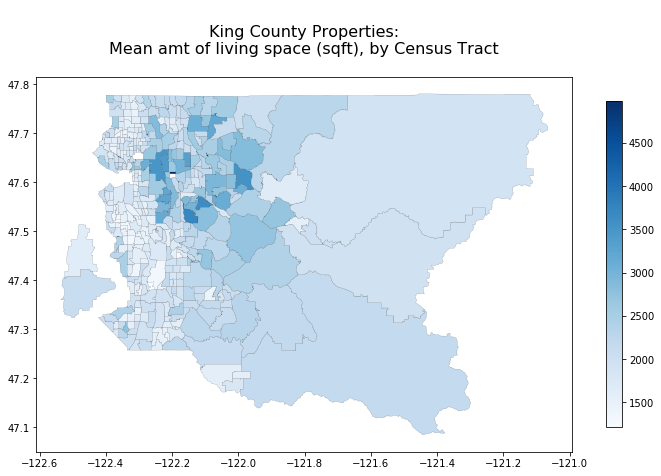

In [44]:
plot_choropleth(geo_tract_stats, 'sqft_living', 'Mean amt of living space (sqft)')

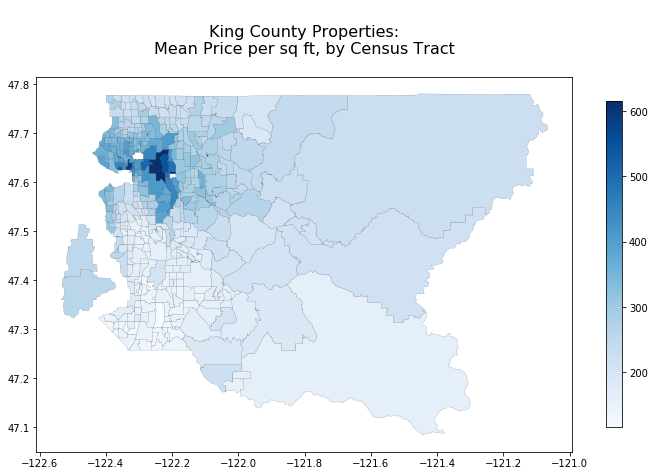

In [45]:
plot_choropleth(geo_tract_stats, 'price_per_sqft', 'Mean Price per sq ft')

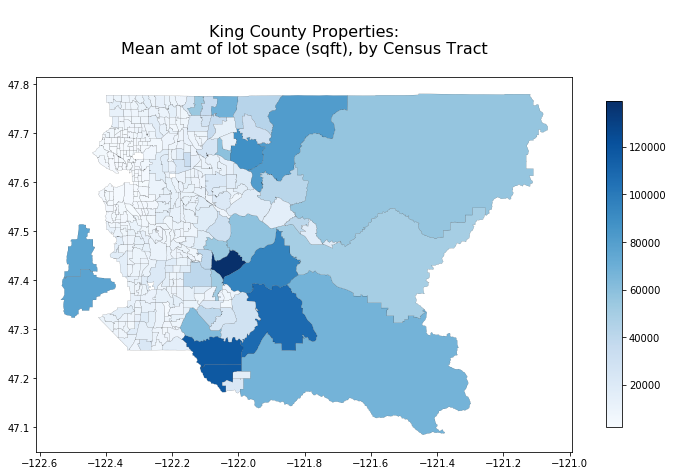

In [46]:
plot_choropleth(geo_tract_stats, 'sqft_lot', 'Mean amt of lot space (sqft)')

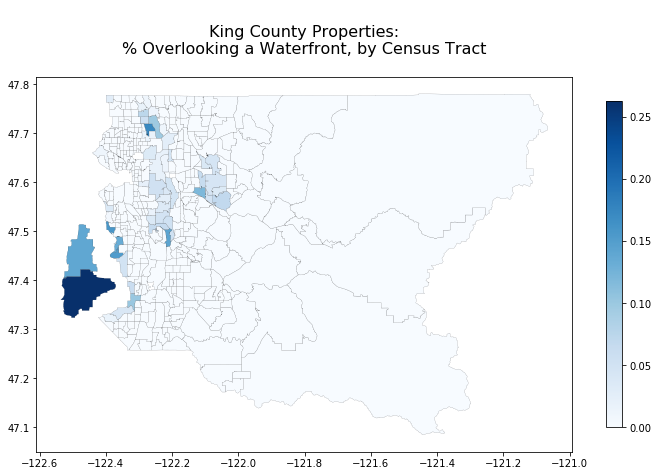

In [47]:
plot_choropleth(geo_tract_stats, 'waterfront', '% Overlooking a Waterfront')

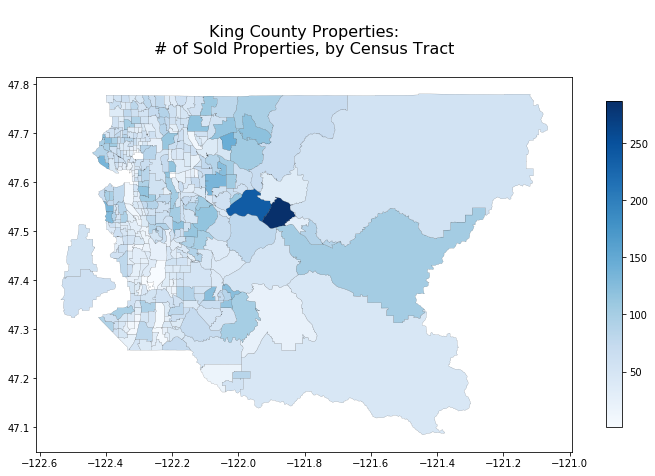

In [48]:
plot_choropleth(geo_tract_stats, 'count', '# of Sold Properties')

note to self: alternatively use `geoplot.choropleth()` directly... couldn't figure out sizing

In [49]:
# geoplot.choropleth(geo_tract_means,
#                    hue = 'sqft_living',
#                    cmap = 'Blues',
#                    linewidth = 0.1);

## find likely distributions

### Check untransformed, log-transformed, and boxcox-transformed

#### overall, winsorizaton effect is very clear. TBD whether that turns out to be good or bad for us, but clearly affects the distributions.

- `price`: best = boxcox -- pretty close.
- `sqft_above`: best = log/boxcox -- log for simplicity -- can easily see the affect of winsorization.
- `sqft_basement`: best = untransformed -- Really bad fit, though --  Too many with no basement.
- `update_age`: best = boxcox -- still a very poor fit.
- `sqft_lot`: best = log/boxcox -- log for simplicity -- can easily see the affect of winsorization.
- `sqft_living`: best = log/boxcox -- log for simplicity -- can easily see the affect of winsorization.
- `sqft_living15`: best = log/boxcox -- log for simplicity -- can easily see the affect of winsorization.
- `sqft_lot15`: best = log/boxcox -- log for simplicity -- can easily see the affect of winsorization.

In [50]:
# function to graphically and statistically compare distribution transformations
def compare_transformations(df, col, const=0):
    
    # set plot and axis properties
    fig, axs = plt.subplots(ncols = 3, nrows = 2)
    fig.set_size_inches(12, 8)
    fig.tight_layout(pad=6.0)
    axs[0][0].title.set_text('QQ plot: ' + col)
    axs[0][1].title.set_text('QQ plot: log(' + col + ')')
    axs[0][2].title.set_text('QQ plot: boxcox(' + col + ')')
    axs[1][0].title.set_text('distribution: ' + col)
    axs[1][1].title.set_text('distribution: log(' + col + ')')
    axs[1][2].title.set_text('distribution: boxcox(' + col + ')')

    # store transformations
    log_col = np.log(df[col] + const) # optionally specify a constant to avoid value=0 errors
    # ignore np.NaN warnings specifically for boxcox transformation
    with np.errstate(invalid='ignore'): 
        # optionally specify a constant to avoid value=0 errors
        boxcox_col = pd.Series(ss.boxcox(df[col] + const)[0])
    
    # make QQ plots
    sm.qqplot(df[col], line = 'q', ax = axs[0][0])
    sm.qqplot(log_col, line = 'q', ax = axs[0][1])
    sm.qqplot(boxcox_col, line = 'q', ax = axs[0][2])

    # make distribution plots
    sns.distplot(df[col], kde=False, ax = axs[1][0])
    sns.distplot(log_col, kde=False, ax = axs[1][1])
    sns.distplot(boxcox_col, kde=False, ax = axs[1][2]);
    
    # normalize columns for ks test
    z_col = (df[col] - df[col].mean()) / df[col].std()
    z_col_log = (log_col - log_col.mean()) / log_col.std()
    z_col_boxcox = (boxcox_col - boxcox_col.mean()) / boxcox_col.std()
 
    # print results of ks test
    print(col + ':')
    print(ss.kstest(z_col.dropna(), 'norm'))
    
    print('\nlog(' + col + '):')
    print(ss.kstest(z_col_log.dropna(), 'norm'))
    
    print('\nboxcox(' + col + '):')
    print(ss.kstest(z_col_boxcox.dropna(), 'norm'))

price:
KstestResult(statistic=0.1457297510025103, pvalue=0.0)

log(price):
KstestResult(statistic=0.025982942946237653, pvalue=4.2791587067255086e-13)

boxcox(price):
KstestResult(statistic=0.013165433219626266, pvalue=0.0011174235342243232)


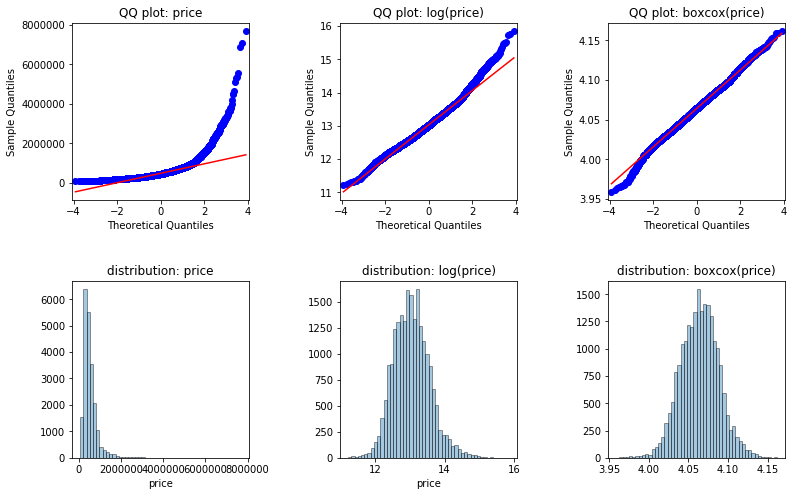

In [51]:
compare_transformations(kc_homes, 'price')

sqft_above:
KstestResult(statistic=0.11540355379106348, pvalue=2.3229985595883542e-250)

log(sqft_above):
KstestResult(statistic=0.04435383400630627, pvalue=2.4095609114869414e-37)

boxcox(sqft_above):
KstestResult(statistic=0.030124219046221035, pvalue=1.865560937647145e-17)


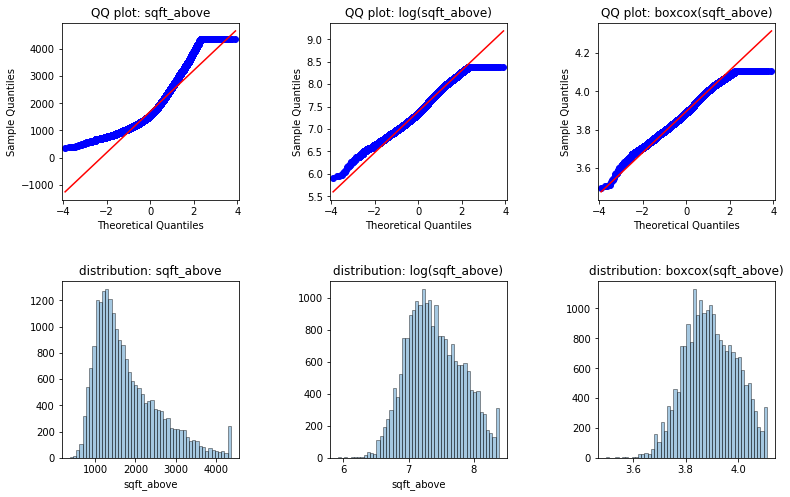

In [52]:
compare_transformations(kc_homes, 'sqft_above', const = 1)

sqft_basement:
KstestResult(statistic=0.35636142239621815, pvalue=0.0)

log(sqft_basement):
KstestResult(statistic=0.3947812435638948, pvalue=0.0)

boxcox(sqft_basement):
KstestResult(statistic=0.3961048461965807, pvalue=0.0)


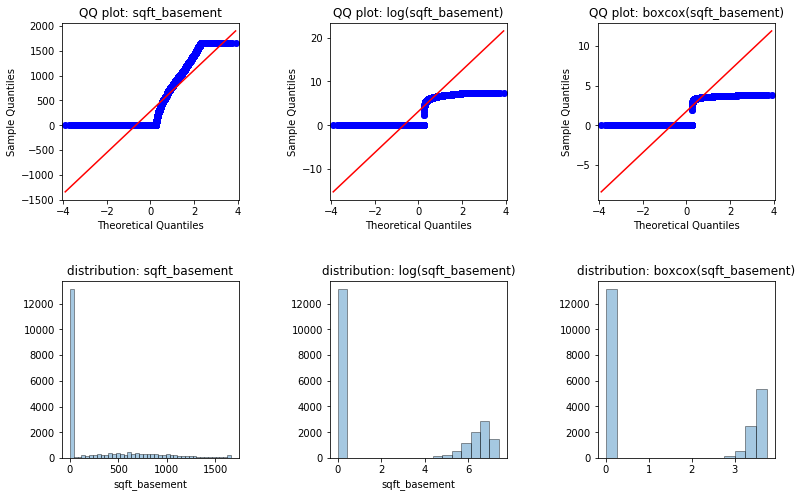

In [53]:
compare_transformations(kc_homes, 'sqft_basement', const = 1)

update_age:
KstestResult(statistic=0.0767792455204588, pvalue=4.6789888464754054e-111)

log(update_age):
KstestResult(statistic=0.11561766679946484, pvalue=2.7400537411935402e-251)

boxcox(update_age):
KstestResult(statistic=0.060586713950608884, pvalue=2.588487171735794e-69)


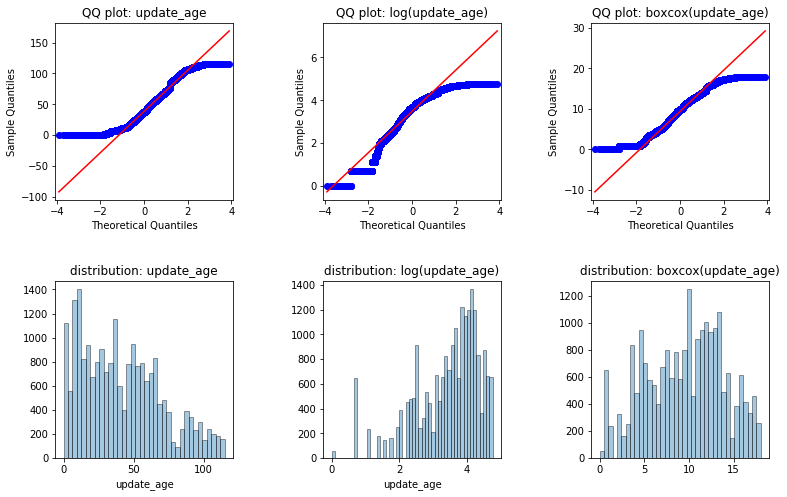

In [54]:
compare_transformations(kc_homes, 'update_age', const = 1)

sqft_lot:
KstestResult(statistic=0.337121604985569, pvalue=0.0)

log(sqft_lot):
KstestResult(statistic=0.12388044994663072, pvalue=1.9946958854978725e-288)

boxcox(sqft_lot):
KstestResult(statistic=0.09361323999238025, pvalue=6.916945976435876e-165)


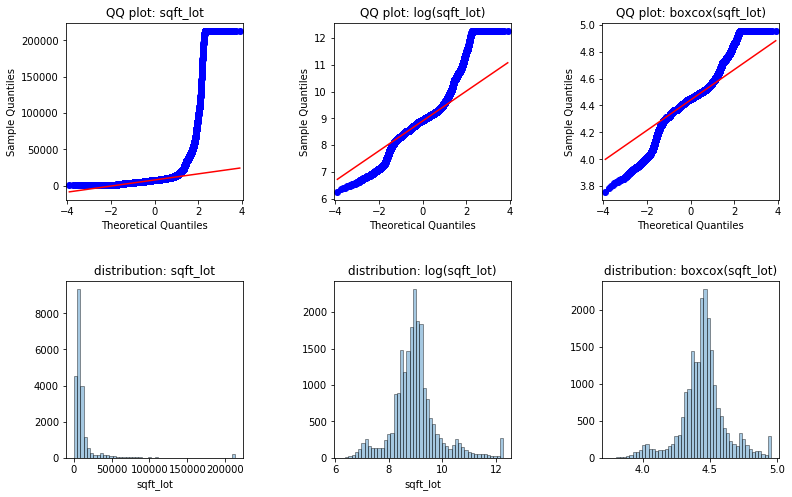

In [55]:
compare_transformations(kc_homes, 'sqft_lot')

sqft_living:
KstestResult(statistic=0.07392704699502844, pvalue=5.456631596785954e-103)

log(sqft_living):
KstestResult(statistic=0.013732806027022648, pvalue=0.0005778465375945998)

boxcox(sqft_living):
KstestResult(statistic=0.010385874930809391, pvalue=0.01891166297375526)


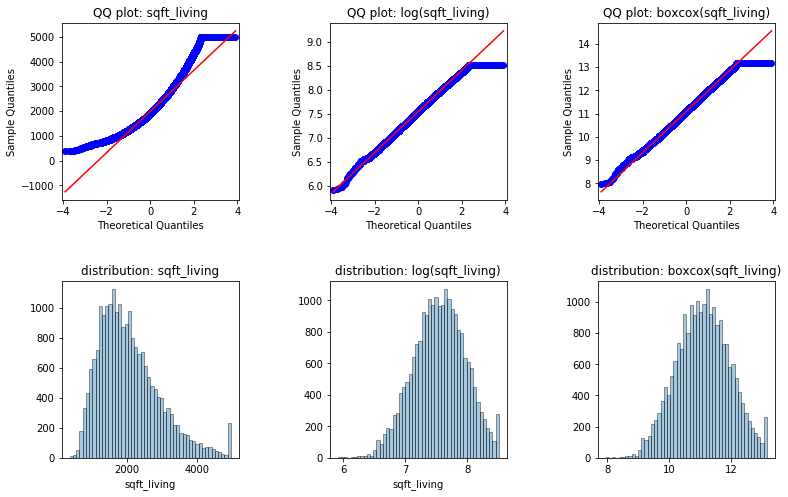

In [56]:
compare_transformations(kc_homes, 'sqft_living')

sqft_living15:
KstestResult(statistic=0.08784702394315191, pvalue=2.9941999652277898e-145)

log(sqft_living15):
KstestResult(statistic=0.03396550776020668, pvalue=4.473845661732849e-22)

boxcox(sqft_living15):
KstestResult(statistic=0.024556852602852508, pvalue=9.637354165746644e-12)


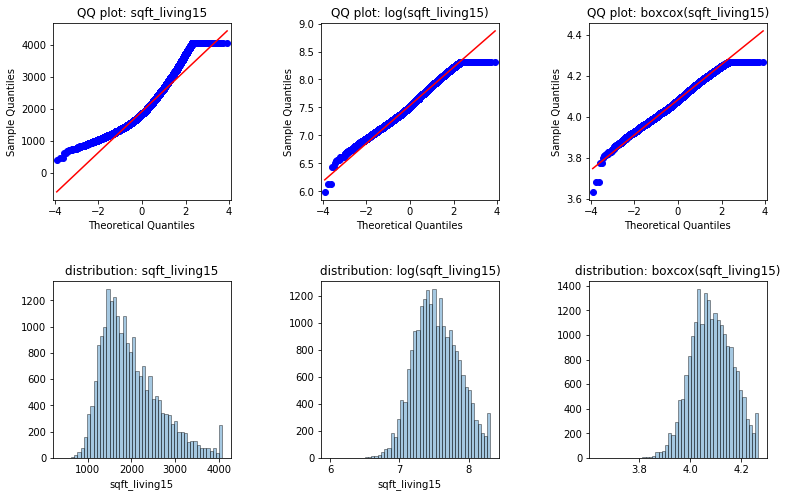

In [57]:
compare_transformations(kc_homes, 'sqft_living15')

sqft_lot15:
KstestResult(statistic=0.3313931768810302, pvalue=0.0)

log(sqft_lot15):
KstestResult(statistic=0.12988746347503366, pvalue=4.92161e-317)

boxcox(sqft_lot15):
KstestResult(statistic=0.10322084767616202, pvalue=2.239016249918303e-200)


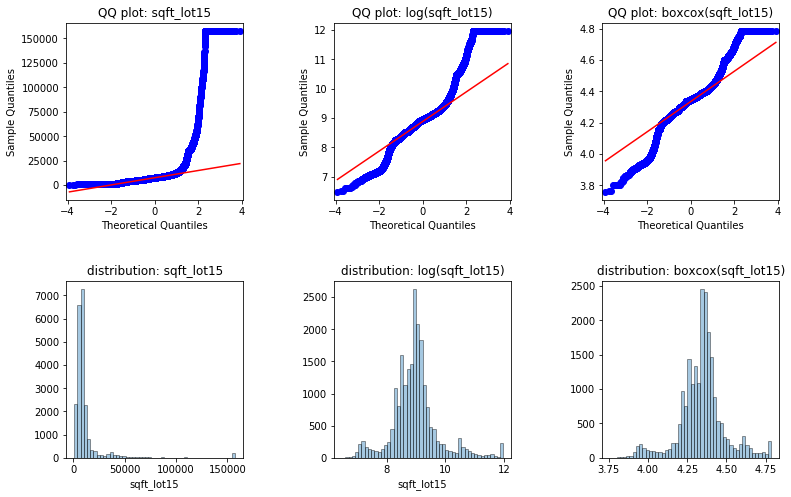

In [58]:
compare_transformations(kc_homes, 'sqft_lot15')

## Compare `mean(price)` by categorical variables, using bootstrap and bayesian methods

### First, use bootstrap methods

- Compute means
- Computer confidence intervals
- Evaluate hypothesis tests

#### Compute means

Notes on bootstrap:
- bootstrap mean = mean(bootstrap_sample_means)
- sample w replacement
- resampling size = original sample size
- works due to the CLT (central limit theorem)

In [59]:
# function to compute bootstrap means on a field, split by a categorical variable
# optional parameter: specify minimum value count of a category for inclusion
def bootstrap_means(df, mean_col, split_col, sample_cnt, min_cnt=5):
    
    # count records in each category & set to NaN if fewer than threshold
    cat_counts = df[split_col].value_counts()
    low_counts = cat_counts[cat_counts < min_cnt].index
    split_col_valid = df[split_col].replace(low_counts, np.NaN)
    
    # valid categories (those w a sufficient # of records)
    cat_prefix = split_col + '_'
    cat_values = split_col_valid.value_counts().index
    cat_index = cat_prefix + cat_values.astype(str)
    
    # df to hold bootstrap results
    results = pd.DataFrame(columns=cat_index)
#     results = pd.DataFrame(columns=split_col+ '_' + cat_index)
    
    # loop through each category in each sample & store its conditional mean
    for i in range(sample_cnt):
        for j, cat in enumerate(cat_values):
            results.at[i, cat_index[j]] = df[mean_col][split_col_valid==cat].sample(
                frac = 1, replace = True).mean()

    return results

In [60]:
# create dfs with mean bootstrap results (each row = 1 sample)
bs_price_bedrooms = bootstrap_means(kc_homes, 'price', 'bedrooms', 1000, min_cnt = 50)
bs_price_view = bootstrap_means(kc_homes, 'price', 'view', 1000, min_cnt = 50)
bs_price_condition = bootstrap_means(kc_homes, 'price', 'condition', 1000, min_cnt = 50)
bs_price_grade = bootstrap_means(kc_homes, 'price', 'grade', 1000, min_cnt = 50)
bs_price_is_renovated = bootstrap_means(kc_homes, 'price', 'is_renovated', 1000, min_cnt = 50)
bs_price_floors = bootstrap_means(kc_homes, 'price', 'floors', 1000, min_cnt = 50)
bs_price_waterfront = bootstrap_means(kc_homes, 'price', 'waterfront', 1000, min_cnt = 50)

#### Compute confidence intervals

- display confidence intervals on plot, to test for statistical differences

In [61]:
# plot the distribution of bootstrap sample means, by category
def plot_bs_means(df, alpha=0.05):
    
    # set figure size, padding
    fig, ax = plt.subplots(nrows = len(df.columns), sharex = True, sharey = True);
    fig.tight_layout(pad=0.5)
    fig.set_size_inches(8, len(df.columns)*2)
    
    # find min & max values across all simulations
    x_min = df.min().min()
    x_max = df.max().max()
    
    # re-order columns
    df = df.reindex(sorted(df.columns), axis=1)
    
    for i, col in enumerate(df.columns):
        
        # mean
        ax[i].axvline(df[col].mean(), color = 'blue', linewidth = 1.5, alpha = 0.2)
        
        # confidence interval
        ax[i].axvline(np.percentile(df[col], (alpha*100)/2.), color='red', linewidth = 2, alpha = 0.2)
        ax[i].axvline(np.percentile(df[col], 100-(alpha*100)/2.), color='red', linewidth = 2, alpha = 0.2)
        
        # axis range
        ax[i].set_xlim([x_min * 0.8, x_max * 1.1])
        
        # plot distribution
        sns.distplot(df[col], ax = ax[i], kde = False)

#### quickly rename the bs_price_grade columns for proper sorting

In [62]:
# add leading 0's to allow for proper sorting
# if we're going to the trouble anyway, lets also remove the decimal points
bs_price_grade = bs_price_grade.rename(
    columns={
        'grade_5.0': 'grade_05', 
        'grade_6.0': 'grade_06',
        'grade_7.0': 'grade_07', 
        'grade_8.0': 'grade_08',
        'grade_9.0': 'grade_09', 
        'grade_10.0': 'grade_10',
        'grade_11.0': 'grade_11', 
        'grade_12.0': 'grade_12',
    })

### make the comparisons

#### H<sub>0</sub> : Mean home sale price is the same regardless of # of bedrooms

We <ins>fail to reject the null hypothesis</ins> for the following comparisons because their confidence intervals overlap:

- 5 vs 6

We <ins>reject the null hypothesis</ins> for the following comparisons because their confidence intervals  do not overlap:

- 1 vs all others
- 2 vs all others
- 3 vs all others
- 4 vs all others
- 5 vs 1 thru 4
- 6 vs 1 thru 4

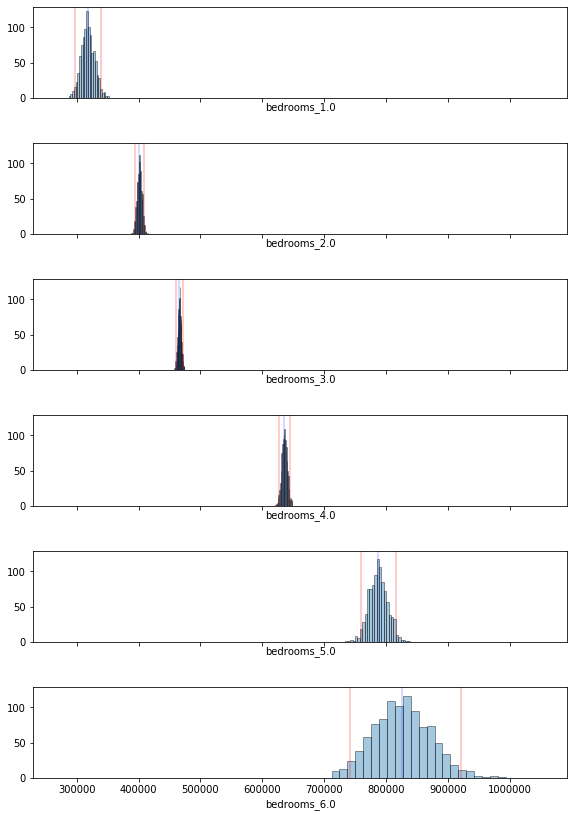

In [63]:
plot_bs_means(bs_price_bedrooms)

***

#### H<sub>0</sub> : Mean home sale price is the same regardless of # view quality

We <ins>fail to reject the null hypothesis</ins> for the following comparisons because their confidence intervals overlap:

- 1 vs 2

We <ins>reject the null hypothesis</ins> for the following comparisons because their confidence intervals  do not overlap:

- 0 vs all others
- 1 vs (0, 3, 4)
- 2 vs (0, 3, 4)
- 3 vs all others
- 4 vs all others

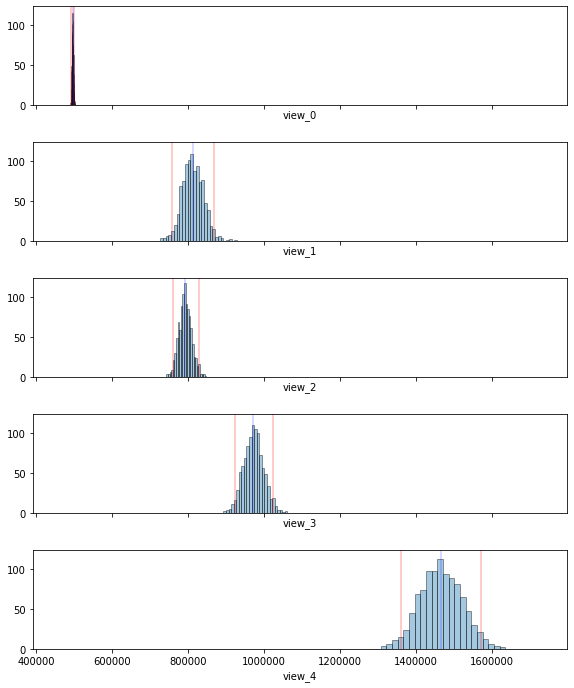

In [64]:
plot_bs_means(bs_price_view)

***

#### H<sub>0</sub> : Mean home sale price is the same regardless of condition

We <ins>fail to reject the null hypothesis</ins> for the following comparisons because their confidence intervals overlap:

- (none)

We <ins>reject the null hypothesis</ins> for the following comparisons because their confidence intervals  do not overlap:

- each pairwise combination

- worth noting that `condition = 3` is above `condition = 4`.  In a one-sided test we would have failed to reject H<sub>0</sub>.

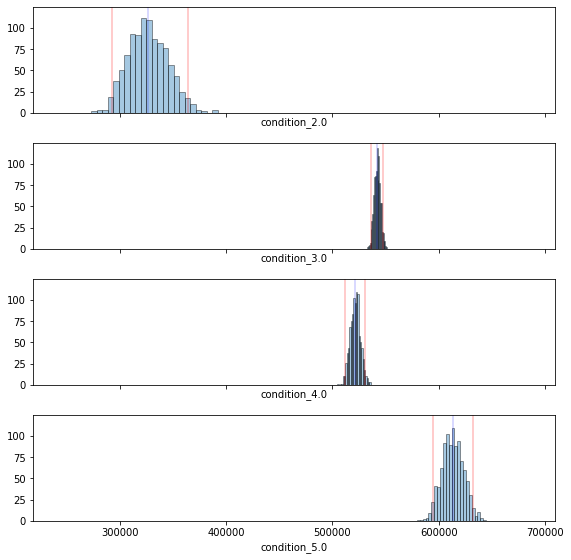

In [65]:
plot_bs_means(bs_price_condition)

***

#### H<sub>0</sub> : Mean home sale price is the same regardless of grade

We <ins>fail to reject the null hypothesis</ins> for the following comparisons because their confidence intervals overlap:

- (none)

We <ins>reject the null hypothesis</ins> for the following comparisons because their confidence intervals  do not overlap:

- each pairwise combination

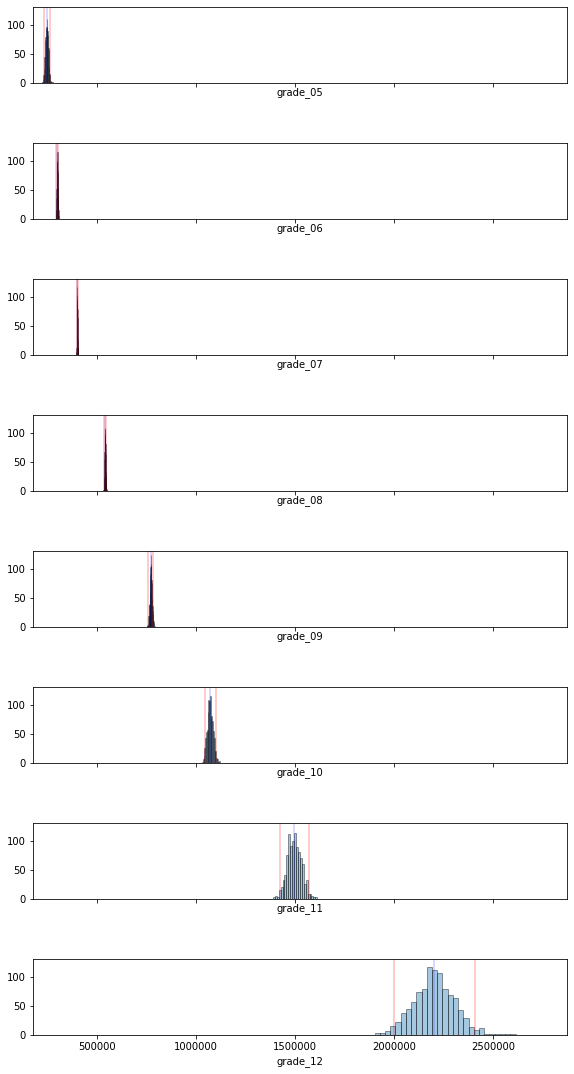

In [66]:
plot_bs_means(bs_price_grade)

***

#### H<sub>0</sub> : Mean home sale price is the same regardless of whether it has been renovated

We <ins>reject the null hypothesis</ins> because their confidence intervals  do not overlap.

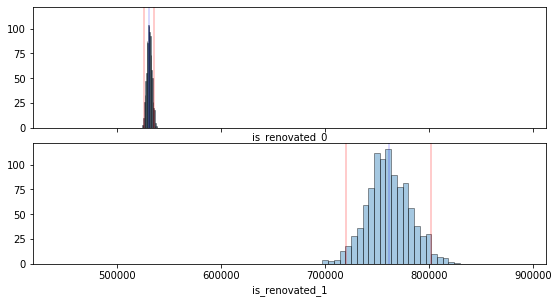

In [67]:
plot_bs_means(bs_price_is_renovated)

***

#### H<sub>0</sub> : Mean home sale price is the same regardless of # of floors

We <ins>fail to reject the null hypothesis</ins> for the following comparisons because their confidence intervals overlap:

- 1.5 vs 3.0

We <ins>reject the null hypothesis</ins> for the following comparisons because their confidence intervals  do not overlap:

- 1.0 vs all others
- 1.5 vs (1.0, 2.0, 2.5)
- 2.0 vs all others
- 2.5 vs all others
- 3.0 vs (1.0, 2.0, 2.5)

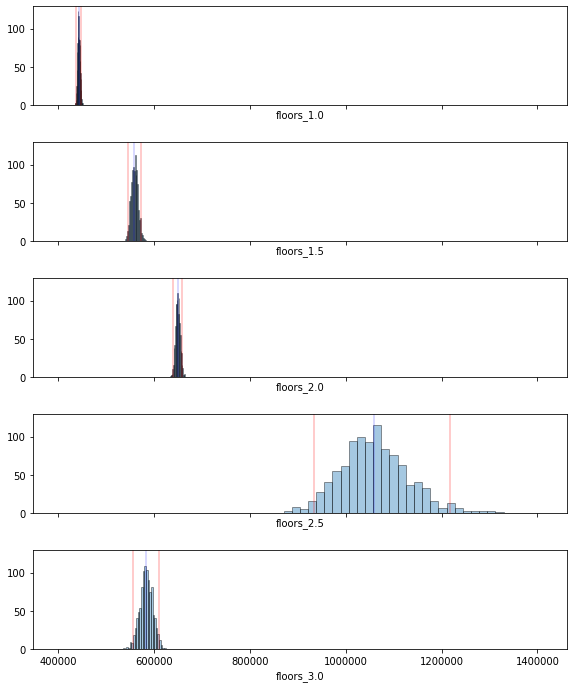

In [68]:
plot_bs_means(bs_price_floors)

***

#### H<sub>0</sub> : Mean home sale price is the same regardless of whether it overlooks a waterfront

We <ins>reject the null hypothesis</ins> because their confidence intervals  do not overlap.

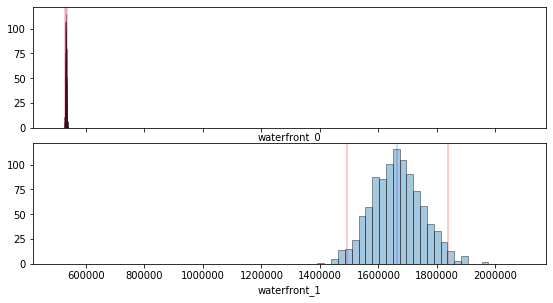

In [69]:
plot_bs_means(bs_price_waterfront);

### Now, use bayesian methods

- Compute means
- Computer confidence intervals
- Evaluate hypothesis tests

#### Compute means

Notes on bayes:
- P(A|B) == K * P(B|A) * P(A) == Posterior is proporitional to [likelihood] * [prior]
- P(Parameters | Data) = P(Data | Parameters) * P(Parameters)
- credible interval is not necessarily symmetric around the mean

In [70]:
# create 10,000 bins from $50K to $2MM, to be used for prior dist
prior_bins = np.linspace(50000, 2000000, num=10000)

# assume prior is normally distributed, with mean price = $600K; std dev = 200K
# (note - these are intentionally naive estimates)
pp = ss.norm.pdf(prior_bins, loc=600000, scale=200000)
pp = pp / pp.sum() # normalize

FYI: alternative prior assumption - assumes prior follows exponential distribution
<br>(center of \\$200K, scale of \\$250K)

In [71]:
# pp = ss.exponnorm.pdf(prior_bins, K = 5, loc=200000, scale=250000)
# pp = pp / pp.sum()

#### functions to compute likelihood & prior

In [72]:
# compute likelihood based on data & chosen bins
def compute_likelihood(p, data): 
    n = len(data) # nbr of rows
    l = np.exp(-n * np.square(data.mean() - p) / (2 * np.var(data))) # likelihood
    return l / l.sum() # normalize

In [73]:
# compute posterior based on prior & likelihood
def posterior(prior, likelihood):
    post = prior * likelihood # product of the probabilities
    return post / sum(post) # normalize

#### For illustration, plot posterior vs prior (including likelihood)

In [74]:
# function to plot posterior vs prior
def plot_post(df, y, x, x_val, bins, prior):
    data = df[y][df[x]==x_val]
    likelihood_val = compute_likelihood(bins, data)
    posterior_val = posterior(prior, likelihood_val)
    
    plt.plot(bins, prior, label='prior')
    plt.plot(bins, likelihood_val, label='likelihood', alpha=.3, linewidth=10)
    plt.plot(bins, posterior_val, label='posterior')
    plt.legend()
    plt.show()

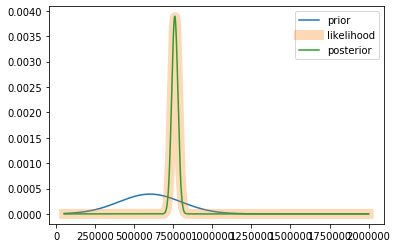

In [75]:
plot_post(kc_homes, 'price', 'is_renovated', 1, prior_bins, pp)

#### Plot confidence intervals

- note: this function only works because we've assumed a symmetric prior distribution

In [76]:
# function to compute credible interval
def plot_ci(df, y, x, x_val, bins, prior, num_samples, lower_q, upper_q):
    
    # compute posterior
    data = df[y][df[x]==x_val]
    likelihood_val = compute_likelihood(bins, data)
    posterior_val = posterior(prior, likelihood_val)
    
    # Compute a large sample by resampling with replacement
    samples = np.random.choice(bins, size=num_samples, replace=True, p=posterior_val)
    ci = np.percentile(samples, [lower_q*100, upper_q*100]) # compute the quantiles
    
    # configure plot output
    interval = upper_q - lower_q
    plt.title('Posterior density with %.3f credible interval' % interval)
    plt.plot(bins, posterior_val, color='blue')
    plt.xlabel(x + ': ' + str(x_val))
    plt.ylabel('Density')
    plt.axvline(x=ci[0], color='red', alpha = 0.6)
    plt.axvline(x=ci[1], color='red', alpha = 0.6)
    print('The %.2f credible interval for %s = %.1f is %.0f to %.0f' 
          % (interval, x, x_val, ci[0], ci[1]))

#### begin hypothesis testing

In [77]:
n = 100000 # set nbr of samples

In [78]:
# define function to loop through the plot_cli() function passing valid category values
def loop_plot_cli(df, y, x, bins, prior, num_samples, lower_q, upper_q):
    min_val = df[x].min()
    max_val = df[x].max()
    
    # keep records from valid categories (50+ records)
    cat_counts = df[x].value_counts()
    low_counts = cat_counts[cat_counts < 50].index
    x_valid = df[x].replace(low_counts, np.NaN)
    
    cat_values = x_valid.value_counts().index.sort_values() # sort values
    
    for _, val in enumerate(cat_values):
        plt.figure(figsize = (4, 2))
        plot_ci(df, y, x, val, bins, prior, num_samples, lower_q, upper_q)

***

#### H<sub>0</sub> : Mean home sale price is the same regardless of # of bedrooms

We <ins>fail to reject the null hypothesis</ins> for the following comparisons because their confidence intervals overlap:

- 5 vs 6

We <ins>reject the null hypothesis</ins> for the following comparisons because their confidence intervals  do not overlap:

- 1 vs all others
- 2 vs all others
- 3 vs all others
- 4 vs all others
- 5 vs 1 thru 4
- 6 vs 1 thru 4

The 0.95 credible interval for bedrooms = 1.0 is 297870 to 339019
The 0.95 credible interval for bedrooms = 2.0 is 394014 to 408836
The 0.95 credible interval for bedrooms = 3.0 is 461101 to 471437
The 0.95 credible interval for bedrooms = 4.0 is 626088 to 644614
The 0.95 credible interval for bedrooms = 5.0 is 756556 to 814671
The 0.95 credible interval for bedrooms = 6.0 is 721062 to 905356


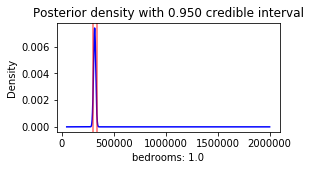

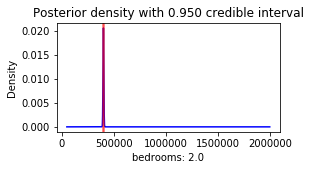

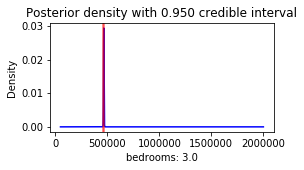

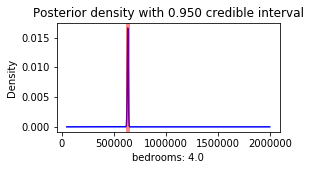

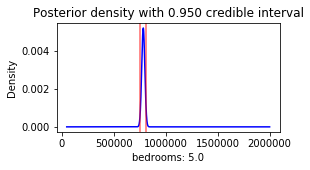

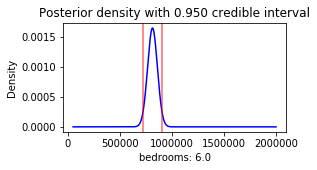

In [79]:
loop_plot_cli(kc_homes, 'price', 'bedrooms', prior_bins, pp, n, .025, .975)

***

#### H<sub>0</sub> : Mean home sale price is the same regardless of # view quality

We <ins>fail to reject the null hypothesis</ins> for the following comparisons because their confidence intervals overlap:

- 1 vs 2

We <ins>reject the null hypothesis</ins> for the following comparisons because their confidence intervals  do not overlap:

- 0 vs all others
- 1 vs (0, 3, 4)
- 2 vs (0, 3, 4)
- 3 vs all others
- 4 vs all others

The 0.95 credible interval for view = 0.0 is 492499 to 500690
The 0.95 credible interval for view = 1.0 is 753825 to 862646
The 0.95 credible interval for view = 2.0 is 759091 to 823257
The 0.95 credible interval for view = 3.0 is 912376 to 1017687
The 0.95 credible interval for view = 4.0 is 1305731 to 1507576


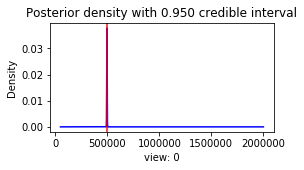

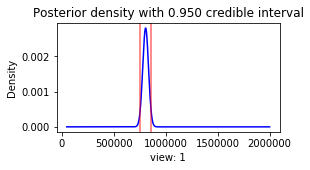

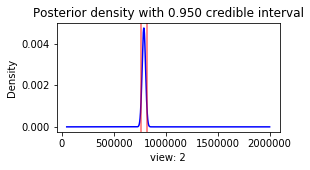

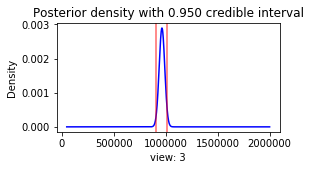

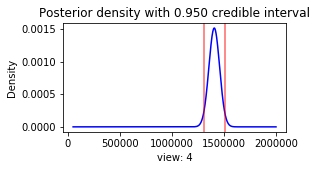

In [80]:
loop_plot_cli(kc_homes, 'price', 'view', prior_bins, pp, n, .025, .975)

***

#### H<sub>0</sub> : Mean home sale price is the same regardless of condition

We <ins>fail to reject the null hypothesis</ins> for the following comparisons because their confidence intervals overlap:

- (none)

We <ins>reject the null hypothesis</ins> for the following comparisons because their confidence intervals  do not overlap:

- each pairwise combination

- worth noting that `condition = 3` is above `condition = 4`.  In a one-sided test we would have failed to reject H<sub>0</sub>.

The 0.95 credible interval for condition = 2.0 is 292994 to 366127
The 0.95 credible interval for condition = 3.0 is 535989 to 547885
The 0.95 credible interval for condition = 4.0 is 512001 to 530723
The 0.95 credible interval for condition = 5.0 is 592739 to 631938


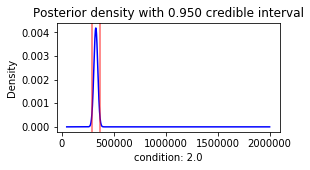

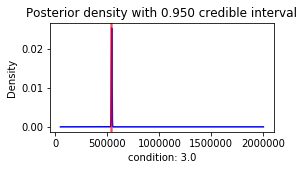

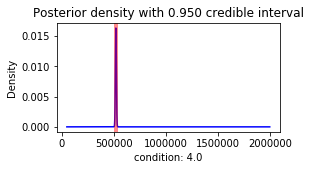

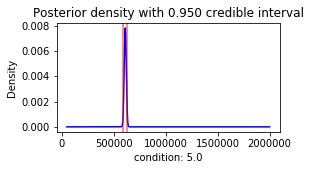

In [81]:
loop_plot_cli(kc_homes, 'price', 'condition', prior_bins, pp, n, .025, .975)

***

#### H<sub>0</sub> : Mean home sale price is the same regardless of grade

We <ins>fail to reject the null hypothesis</ins> for the following comparisons because their confidence intervals overlap:

- (none)

We <ins>reject the null hypothesis</ins> for the following comparisons because their confidence intervals  do not overlap:

- each pairwise combination

The 0.95 credible interval for grade = 5.0 is 233903 to 263936
The 0.95 credible interval for grade = 6.0 is 296700 to 307231
The 0.95 credible interval for grade = 7.0 is 399280 to 405911
The 0.95 credible interval for grade = 8.0 is 537549 to 548275
The 0.95 credible interval for grade = 9.0 is 761041 to 785419
The 0.95 credible interval for grade = 10.0 is 1041284 to 1097255
The 0.95 credible interval for grade = 11.0 is 1401290 to 1537999
The 0.95 credible interval for grade = 12.0 is 1649550 to 1979523


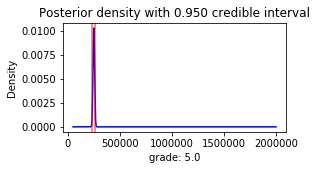

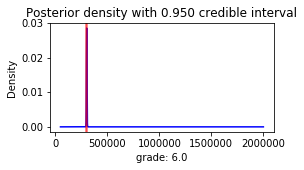

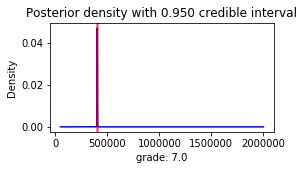

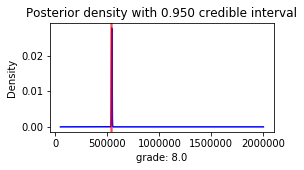

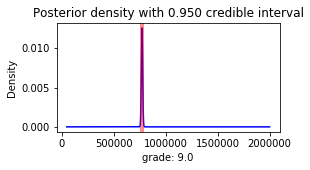

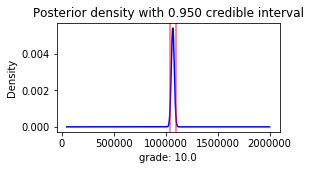

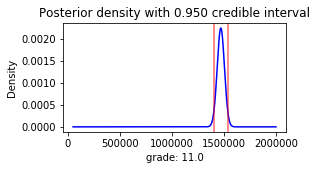

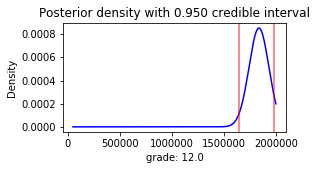

In [82]:
loop_plot_cli(kc_homes, 'price', 'grade', prior_bins, pp, n, .025, .975)

***

#### H<sub>0</sub> : Mean home sale price is the same regardless of whether it has been renovated

We <ins>reject the null hypothesis</ins> because their confidence intervals  do not overlap.

The 0.95 credible interval for is_renovated = 0.0 is 525653 to 535209
The 0.95 credible interval for is_renovated = 1.0 is 719697 to 798095


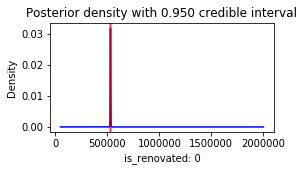

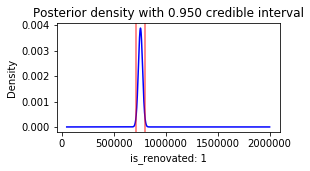

In [83]:
loop_plot_cli(kc_homes, 'price', 'is_renovated', prior_bins, pp, n, .025, .975)

***

#### H<sub>0</sub> : Mean home sale price is the same regardless of # of floors

We <ins>fail to reject the null hypothesis</ins> for the following comparisons because their confidence intervals overlap:

- 1.5 vs 3.0

We <ins>reject the null hypothesis</ins> for the following comparisons because their confidence intervals  do not overlap:

- 1.0 vs all others
- 1.5 vs (1.0, 2.0, 2.5)
- 2.0 vs all others
- 2.5 vs all others
- 3.0 vs (1.0, 2.0, 2.5)

The 0.95 credible interval for floors = 1.0 is 437309 to 447255
The 0.95 credible interval for floors = 1.5 is 545350 to 572652
The 0.95 credible interval for floors = 2.0 is 639544 to 658266
The 0.95 credible interval for floors = 2.5 is 887999 to 1138989
The 0.95 credible interval for floors = 3.0 is 556271 to 609706


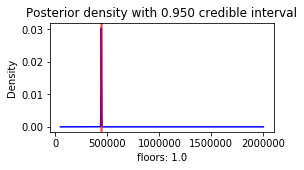

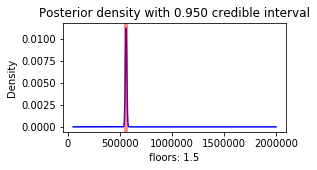

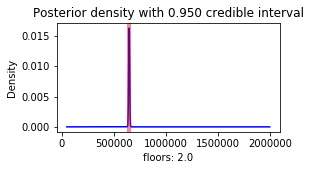

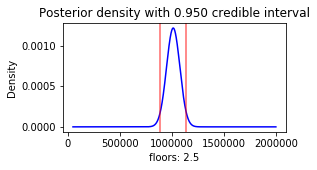

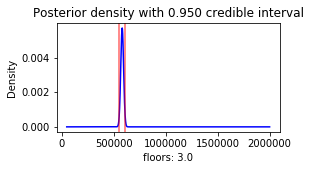

In [84]:
loop_plot_cli(kc_homes, 'price', 'floors', prior_bins, pp, n, .025, .975)

***

#### H<sub>0</sub> : Mean home sale price is the same regardless of whether it overlooks a waterfront

We <ins>reject the null hypothesis</ins> because their confidence intervals  do not overlap.

The 0.95 credible interval for waterfront = 0.0 is 527018 to 536184
The 0.95 credible interval for waterfront = 1.0 is 1333813 to 1647990


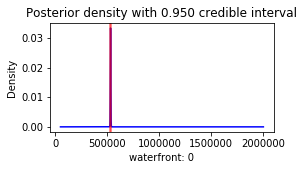

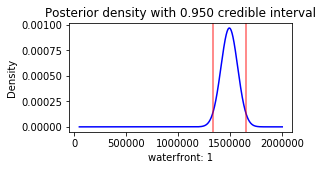

In [85]:
loop_plot_cli(kc_homes, 'price', 'waterfront', prior_bins, pp, n, .025, .975)